### Notebook for testing age model new features

In [6]:
import sys
sys.path.insert(0, "..")

import os
import pandas as pd
import numpy as np
import scipy.io as so
from datetime import datetime 
import datetime as dt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
# pip install opencv-python
import cv2
from PIL import Image
import imutils
from torch.optim import Adam
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel
import torch.nn as nn
from transformers import Trainer
import matplotlib.pyplot as plt
from datetime import datetime
from transformers import get_linear_schedule_with_warmup
from utils import generate_masks
import dlib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from main import FaceAgeDataset

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

def generate_df_from_mat(data_dir, csv_path, feature_extractor, dataset_type="wiki"):
    csv_dir = "/home/jessekim/data"
    logs_dir = "/home/jessekim/logs"
    metadata_path = os.path.join(data_dir, dataset_type + ".mat")

    meta = so.loadmat(metadata_path)
    data = meta[dataset_type]
    
    #parse through matlab file 
    dob = data[0][0][0].flatten()
    photo_taken = data[0][0][1].flatten()
    full_path = np.array([i[0] for i in data[0][0][2].flatten()])
    gender = data[0][0][3].flatten()
    name = [i[0] if len(i) > 0 else "" for i in data[0][0][4].flatten()]
    face_location = [i[0] for i in data[0][0][5].flatten()]
    face_score = data[0][0][6].flatten()
    second_face_score = data[0][0][7].flatten()
    
    #create dict from values
    parsed = {
        "dob": dob,
        "photo_taken": photo_taken,
        "full_path": full_path,
        "gender": gender,
        "name": name,
        "face_location": face_location,
        "face_score": face_score,
        "second_face_score": second_face_score    
    }
    full_data = pd.DataFrame(parsed)
    
    # 
    face_present = full_data[np.isfinite(full_data["face_score"])]

    #make sure no bounding boxes are [1,1,1,1] which means no face to be found
    assert len(face_present[face_present["face_location"].astype(str) == "[1 1 1 1]"]) == 0

    #len(full_data[pd.isnull(full_data)["gender"]]) #2643 are genderless

    #dataframe with second faces removed:
    primary = face_present[pd.isnull(face_present["second_face_score"])]

    #get rid of cols don't need
    primary = primary.drop(["second_face_score"],axis=1).reset_index(drop=True)
    
    
    # add in birthdays
    birthday = primary["dob"].apply(datenum_to_datetime)
    age = primary["photo_taken"] - birthday
    primary["age"] = age
    primary = primary

    #assume need to be at least 1 year old
    primary = primary[primary.age >= 1]
    
    #add in age and remove humans outside age range
    primary = primary.drop(["dob"],axis=1)
    primary = primary[primary.age < 100].reset_index(drop=True)

    #add in bounds and save to csv
    bounds = pd.DataFrame(primary["face_location"].to_list(), columns = ["bound0", "bound1", "bound2", "bound3"])
    primary = pd.concat([primary, bounds],axis=1)#.drop("face_location",axis=1)

    primary.to_csv(csv_path, index=False)
    
#function to parse datetime in matlab to python
def datenum_to_datetime(datenum, age=False):
    """
    source: https://gist.github.com/victorkristof/b9d794fe1ed12e708b9d
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    try:
        days = datenum % 1
        datetime_ = datetime.fromordinal(int(datenum)) \
               + dt.timedelta(days=days) \
               - dt.timedelta(days=366)

        return datetime_.year #, round((datetime.now() - datetime_).days / 365.25)
    except:
        return np.inf


def create_imdb_joint_csvs():
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')


    #paths and load in matlab file of wikipedia image metadata
    csv_dir = "/home/jessekim/data"
    logs_dir = "/home/jessekim/logs"

    wiki_data_dir = "/home/jessekim/data/wiki_crop/"
    imdb_data_dir = "/home/jessekim/data/imdb_crop"

    wiki_csv_path = "/home/jessekim/data/face_age_processed_data.csv"
    imdb_csv_path = "/home/jessekim/data/imdb_face_age_processed_data.csv"

    generate_df_from_mat(wiki_data_dir, wiki_csv_path, feature_extractor, "wiki")
    generate_df_from_mat(imdb_data_dir, imdb_csv_path, feature_extractor, "imdb")

    ### create final wiki_imdb train_test splits
    wiki = pd.read_csv(wiki_csv_path)
    imdb = pd.read_csv(imdb_csv_path)

    wiki["full_path"] = "wiki_crop/" + wiki["full_path"]
    imdb["full_path"] = "imdb_crop/" + imdb["full_path"]

    imdb_wiki = pd.concat([wiki, imdb]).reset_index(drop=True)

    shuffled = imdb_wiki.sample(frac=1, random_state=42).reset_index(drop=True)
    shuffled = shuffled.drop(["photo_taken", "gender", "name", "face_location", "face_score"],axis=1)

    #make train/test splits
    valid_idx = int(len(imdb_wiki) * .05)
    test_idx = int(len(imdb_wiki) * .15)

    valid = shuffled.iloc[:valid_idx]
    test = shuffled.iloc[valid_idx : valid_idx + test_idx]
    train = shuffled.iloc[valid_idx + test_idx :]
    print(valid.shape, test.shape, train.shape)

    valid.to_csv(os.path.join(csv_dir, "imdb_wiki_valid.csv"),index=False)
    test.to_csv(os.path.join(csv_dir, "imdb_wiki_test.csv"),index=False)
    train.to_csv(os.path.join(csv_dir, "imdb_wiki_train.csv"),index=False)
    print("done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
%%time
create_imdb_joint_csvs()

(11227, 6) (33682, 6) (179638, 6)
done
CPU times: user 1min 7s, sys: 719 ms, total: 1min 8s
Wall time: 1min 8s


### Example output of Mask Creation + processing

In [4]:
from torchvision.transforms import ToTensor
from utils import generate_masks

img_path = os.path.join("/home/jessekim/data/wiki_crop/64/33771064_1945-02-13_2015.jpg") 


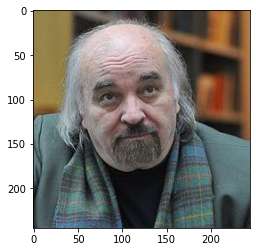

In [5]:
img = Image.open(img_path)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


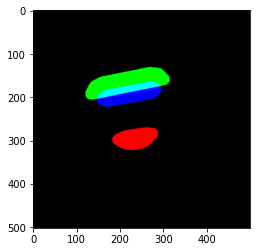

In [6]:
plt.imshow(generate_masks(img_path, regions=True)[:,:,:3])

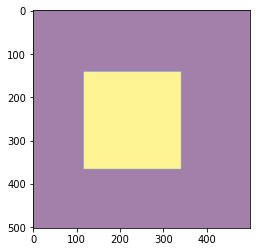

In [7]:
plt.imshow(generate_masks(img_path, box = True), alpha=0.5)

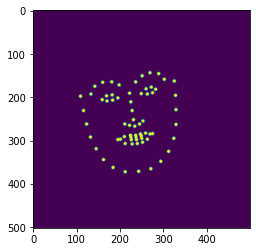

In [8]:
out = generate_masks(img_path)
plt.imshow(generate_masks(img_path))

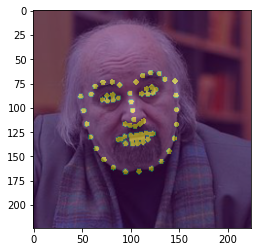

In [9]:
#showing the preprocessing image and mask:
out = generate_masks(img_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k', do_normalize=False)

feature_extractor_mask = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k', do_normalize=False)
im = transforms.ToPILImage()(np.uint8(out))
vals = feature_extractor_mask(im)["pixel_values"][0]
val = transforms.ToTensor()(vals)
plt.imshow(feature_extractor(img)["pixel_values"][0])
plt.imshow((val > 0).permute(1,2,0).int(),alpha=0.5)
np.unique(im,return_counts=True), np.unique((val > 0).int(),return_counts=True)


img = cv2.imread(img_path)


In [11]:
#loading the dataloader
wiki_csv_path = "/home/jessekim/data/face_age_processed_data.csv"

dataset = FaceAgeDataset(wiki_csv_path, mask_info = "BOX", data_source ="wiki")
train_d = DataLoader(dataset, batch_size=64,
                        shuffle=False, num_workers=16)

wiki


In [27]:
for idx, i in enumerate(train_d):
    img = i[0]
    labels = i[1]
    break

In [28]:
from datasets import Features, ClassLabel, Array3D
features = Features({
    'label': ClassLabel(names = np.arange(1,99)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

### Model Exploration

In [36]:
device = "cuda"
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device);

POOLED_SIZE = 768
CATEGORIES = 99
classifier = nn.Sequential(
    nn.Linear(POOLED_SIZE, CATEGORIES),
    nn.LogSoftmax())
classifier.to(device);

#loss is MAE
loss = torch.nn.L1Loss()

In [37]:
outs = model(img.to(device))

In [38]:
class VisionTransformer(torch.nn.Module):
    def __init__(self, pooled_size, categories):
        super(VisionTransformer, self).__init__()
        self.POOLED_SIZE = pooled_size
        self.CATEGORIES = categories
        
#         self.feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.model_ = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        
        self.HIDDEN_SIZE = self.model_.config.hidden_size
        
        self.classifier = nn.Sequential(
        nn.Linear(self.POOLED_SIZE, self.CATEGORIES),
        nn.Softmax())

    def forward(self, x):
        out = self.model_(x)
        #use last hidden layer
        softmaxes = self.classifier(out["last_hidden_state"][:,0,:])
        
        classes = torch.tensor(np.arange(1,self.CATEGORIES + 1).reshape(-1, 1)).float()
        exp_age = torch.matmul(softmaxes, classes)

#         out = self.classifier(out["pooler_output"])
        return exp_age
        

In [39]:
LOGS_DIR = "logs"
LOG_CSV_PATH = 'logs/exp_tracker.csv'


def run_one_epoch(model, dataloader, optimizer, scheduler, loss, train=True):
    
    loss_vals = 0
    acc = 0
    total_count = 0
    
    if train:
        model.train()
    else:
        model.eval()
        
    for _, (img, label, mask) in enumerate(dataloader):
        #pipe everything over to device
        img.to(device)
        label.to(device)
        mask.to(device)

        #put through model and classifier
        out = model(img)

        #loss:
        output = loss(out, label)
        loss_vals += output.item()
        
        #accuracy per epoch
        acc += (torch.argmax(out, axis=1) == label).sum().item()
        total_count += len(label)
        
        if train:
            
            #make sure optimizer grad is 0, then update grad based on backwards, then step to update weights
            optimizer.zero_grad()
            output.backward()
            optimizer.step()
            
    if train:
        scheduler.step()
            
        
    return model, loss_vals, acc/total_count

    
def setup_exp(log_csv_path, logs_dir, exp_name):
    #set up csv for experiment tracker, unless already present
    if os.path.exists(log_csv_path):
        pass
    else:
        pd.DataFrame(columns = ("experiment_name", "model_type", "date", "lr", "patience", "epochs", "seed")).to_csv('logs/exp_tracker.csv')
    
    curr_exp_path = os.path.join(logs_dir, exp_name + ".csv")
    
    #set up csv for specific experiment (make a new one each time):
    pd.DataFrame(columns = ("experiment_name", "date", "epoch", "loss", "accuracy")).to_csv('logs/exp_tracker.csv')
    
    
def log_output(exp_name, epoch, loss, acc, train):
    curr_exp_path = os.path.join(logs_dir, exp_name + ".csv")
    date = datetime.now().date().strftime("%D")
    with open(curr_exp_path, "a") as fd:
        fd.write(",".join([exp_name,train,date,str(epoch),str(np.round(loss,5)),str(np.round(acc,5))]) + "\n")
    
    
def log_experiment(log_csv_path, exp_name, model_type, lr, patience_limit, num_epochs, seed):
    with open(log_csv_path,'a') as fd:
        fd.write(",".join([exp_name, model_type, datetime.now().date().strftime("%D"), str(lr), str(patience_limit), str(num_epochs), str(seed)]) + "\n")

In [42]:
import torchvision.models as models

densenet = models.densenet161(pretrained=True)
densenet.classifier = nn.Sequential(
        nn.Linear(2208, 99),
        nn.Softmax())

model = VisionTransformer(POOLED_SIZE, CATEGORIES)

### Attempt at using the HuggingFace trainer
- Something to keep in mind is that transformers generally need a certain training regiment.

In [88]:
# from transformers import Trainer
# # https://huggingface.co/transformers/training.html
# training_args = TrainingArguments("test_trainer")
# ! pip install datasets
# https://theaisummer.com/hugging-face-vit/ 
# example VIT


# from datasets import list_metrics, load_metric
# from transformers import default_data_collator, TrainingArguments

# data_collator = default_data_collator
# trainer = Trainer(
#     model=model, args=training_args, train_dataset=small_train_dataset, eval_dataset=small_eval_dataset
# )

# trainer.train()
def compute_metrics(eval_pred):
    metric = MAE
    predictions, labels = eval_pred
    return metric(predictions, labels)

We train all models, including ResNets, using Adam (Kingma & Ba,
2015) with β1 = 0.9, β2 = 0.999, a batch size of 4096 and apply a high weight decay of 0.1, which
we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common
practices, Adam works slightly better than SGD for ResNets in our setting). We use a linear learning
rate warmup and decay, see Appendix B.1 for details. For fine-tuning we use SGD with momentum,
batch size 512, for all models, see Appendix B.1.1. For ImageNet results in Table 2, we fine-tuned at
higher resolution: 512 for ViT-L/16 and 518 for ViT-H/14, and also used Polyak & Juditsky (1992)
averaging with a factor of 0.9999 (Ramachandran et al., 2019; Wang et al., 2020b).

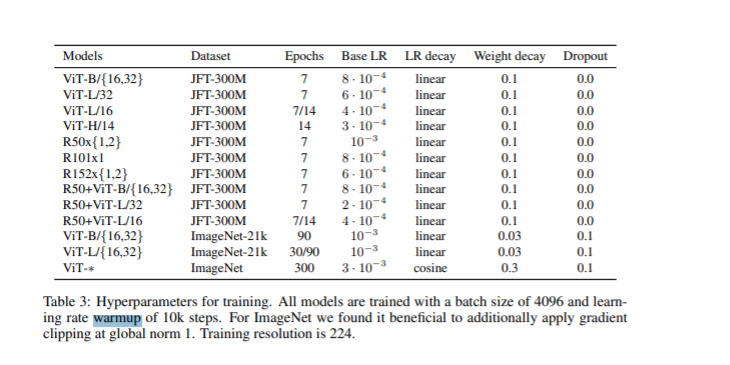

In [47]:
# ### experimenting with Hugging face trainer method:
# args = TrainingArguments(
# #     no_cuda = True,
#     output_dir="test-vit",
#     seed=42,
#     evaluation_strategy = "steps",
#     learning_rate=2e-5,
#     dataloader_num_workers=4,
#     per_device_train_batch_size=1,
#     per_device_eval_batch_size=1,
#     num_train_epochs=100,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model='loss',
#     save_total_limit=20,
#     logging_dir='logs',
#     eval_steps = 1,
# )

# trainer = Trainer(
#     model, 
#     args, 
#     train_dataset=train_loader,
#     eval_dataset=valid_loader,
#     data_collator = data_collator,
#     compute_metrics = compute_metrics
# )

# trainer.train()